# Przykłady zastosowania API TREZOR-a

### UPDATE: 17/09/23

Dzisiaj z serii ciekawe publiczne dane, o których istnieniu mało kto wie będzie o przejrzystości budżetu państwa. 

Otóż ostatnio widziałem na Twitterze kilka wpisów osób, które uzyskały informacje w trybie dostępu do informacji publicznej odnośnie dochodów budżetu państwa. Sprowadziło się to do przekazania informacji, które są już dostępne, tylko że w formie oficjalnego pisma. Nie wiem dlaczego ktoś taką formę preferuje, może to zwyczajnie wynika z braku wiedzy. Tym krótkim wpisem mam nadzieję, że tą wiedzą się podzielę.

**DISCLAIMER:** Nie pracuję przy opracowaniu tej aplikacji (API TREZOR), ale zdarza mi się pracować z tymi danymi, ale w innej formie i zakresie. Tutaj tylko jako ciekawostka i przykład co można z publicznie dostępnych danych wyciągnąć. Nie jest to żadna opinia, argument czy zaawansowana analiza. Jedyne co chcę tu pokazać, że MF udostępnia ciekawe dane i warto to rozpropagować.

Planowanie i koordynacja dochodów i wydatków w administracji, gdzie mamy wiele odrębnych jednostek stanowi nie lada wyzwanie. W tym celu powstał system TREZOR. Jest to wewnętrzny system MF pozwalający nie tylko na planowanie, ale też służący sprawozdawczości dochodów i wydatków. Dla zainteresowanych jak wygląda praca z TREZOR-em od środka MF udostępnia [dokumentację na stronie](https://www.gov.pl/web/finanse/dokumentacja-uzytkownika-trezor).

Przyznam się szczerze, że sam niedawno odkryłem, że **MF udostępnia te dane bezpłatnie, wszystkim, bez konieczności rejestracji**. Dzięki temu wydaje mi się, że MF ma chyba jeden z najbardziej czytelnych i otwartych mechanizmów planowania i sprawozdawczości miesięcznej dochodów i wydatków. API wraz z dokumentację dostępne jest tutaj: [Swagger UI (mf.gov.pl)](https://trezor-api.mf.gov.pl/dev/index.html).

Co tam znajdziemy? Plany wydatków i dochodów, wykonanie miesięczne powyższego oraz słowniki. Dlaczego tak? A bo ustawa o finansach publicznych określa co należy sprawozdawać. Ponadto ustawa określa [szczegółową klasyfikację dochodów i wydatków zawartą w rozporządzeniu Szczegółowa klasyfikacja dochodów, wydatków, przychodów i rozchodów oraz środków pochodzących ze źródeł zagranicznych. - Dz.U.2022.513 t.j. - OpenLEX](https://sip.lex.pl/akty-prawne/dzu-dziennik-ustaw/szczegolowa-klasyfikacja-dochodow-wydatkow-przychodow-i-rozchodow-oraz-17606051). Dzięki temu można na podstawie kodu działu/rozdziału określić na co jest dany wydatek, z czego dochód oraz paragrafu jaki to rodzaj operacji. To wszystko jest.

Ze słowników warto zwrócić uwagę na ‘jednostki budżetowe’, dzięki czemu można zidentyfikować jakiej jednostki dotyczą określone wydatki bądź dochody. Przydaje się np. przy okazji rozdzielania wydatków na jednostki będące pod nadzorem wojewodów. Bez tej identyfikacji wydatki byłyby liczone podwójnie. 

Najważniejsze dane stanowią jednak sprawozdania:

* Rb-27 czyli sprawozdanie z wykonania planu dochodów budżetowych,
* Rb-28 czyli sprawozdanie z wykonania planu wydatków budżetu państwa.

Format danych oraz instrukcję sporządzania sprawozdań określa [Rozporządzenie Ministra Finansów z dnia 11 stycznia 2022 r. w sprawie sprawozdawczości budżetowej (sejm.gov.pl)](https://isap.sejm.gov.pl/isap.nsf/DocDetails.xsp?id=WDU20220000144).

Te dane zawierają absolutnie wszystko jeśli chodzi o budżet państwa i łatwo się też tego powodu w nich pogubić. Uwaga, **nie ma tutaj ujętych funduszy typu FUS, FER czy NFZ**, ale o tym może kiedy indziej. 

In [46]:
# MN 27/05/23

# Pakiety
library(data.table)
library(magrittr)
library(ggplot2)
library(gridExtra)

library(knitr)
library(kableExtra)

# Oprócz tego korzystam httr, jsonlite oraz IRkernel do połaczenia z Jupyter

# Określenie czy korzystamy z API REST-owego czy też z serwera SQL
czy_api <- TRUE

if (czy_api == FALSE){

  ######################################################################
  # Używam PostreSQL
  library(RPostgreSQL)


  # Parametry połączenia z serwerem PostgreSQL zmiennych środowiskowych
  # Można zastąpić str
  db_param <- list(
    user = Sys.getenv("DB_USER"),
    pass = Sys.getenv("DB_PASS"),
    base = Sys.getenv("DB_BASE"),
    host = Sys.getenv("DB_HOSTNAME")
  )
  drv <- dbDriver("PostgreSQL")
  con <- dbConnect(
      drv, 
      user = db_param$user, 
      password = db_param$pass, 
      dbname = db_param$base, 
      host = db_param$host

  )
}

######################################################################
# Ustawienia wyświetlania dla ggplot
theme_set(theme_bw())  
theme_update(legend.position="bottom", text = element_text(size = 20))
# Kolory: https://www.datanovia.com/en/blog/ggplot-colors-best-tricks-you-will-love/
# The palette with grey:
cbp1 <- c("#999999", "#E69F00", "#56B4E9", "#009E73",
          "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
color_fill <- scale_fill_manual(values = cbp1)
# To use for line and point colors, add
color_color <- scale_colour_manual(values=cbp1)

pperc <- function(x) sprintf("%1.1f%%", 100*x)

## Dostęp do danych

Dane dostępne są w postaci API REST-owego. Format dostępu do danych wraz z opisami pól oraz przykładami jak niektóre rzeczy pobrać jest szczegółowo udokumentowany na stronie [MF: Swagger UI (mf.gov.pl)](https://trezor-api.mf.gov.pl/dev/index.html). To znaczy, że można skonstruować skrypty do automatycznego odpytywania i ściągania danych. Można, znaczy napisałem i się dzielę.

Skrypty zaciągają w R dane z API i zapisują do bazy PostgresSQL. Trwa to dość długo, bo API ma ograniczenie do liczby zapytań na godzinę, a danych jest dużo, bo od 2015 r. Póki co dałem przełącznik `czy_api`, który pozwala wybrać czy dane zaczytywać z bazy SQL (szybciej) czy też z API MF (bez konieczności kompletowania całej bazy).

Dla niecieprliwych udostępniłem skompresowane dane od I 2015 do IV 2023 na swojej stronie [link](https://maten.pl/files/trezor_20230628.zip). Są to skompresowane pliki CSV, ale w przypadku Rb-28 i Rb-27 umieściłem całość oraz przefiltrowane o nadrzędnych dysponentów z dopiskiem `_bp`. Dzięki temu powinno się uniknąć liczenia podwójnie. Proszę tylko o podawanie MF jako źródła danych wraz z odnośnikiem do API TREZOR-a [https://trezor-api.mf.gov.pl/dev/index.html](https://trezor-api.mf.gov.pl/dev/index.html).

Zasadnicza część zawarta jest w pliku `pobierz_trezor.R`. Zawiera on listę z linkami do poszczególnych elementów API oraz funkcję `pobierz_trezor()`, która obsługuje API za pomocą następujących parametrów:

* **url** - adres czyli element z listy `trezor_api`,
* **param** - lista z filtrami do API. Należy podać co najmniej rok, ale można też inne elementy,
* **sleep** - odstęp pomiędzy zapytaniami w sekundach. Potrzebujemy tego żeby serwery MF nas nie wyrzuciły,
* **callback** - funkcja do ewentualnego wykonania po zaczytaniu fragmentu danych. Tutaj w pozostałych skryptach umieszczam funkcję do wrzucania danych do bazy SQL.

Na wyjściu funkcja zwraca listę z elementami w postaci `data.table`.

In [2]:
# Linki do poszczególnych zbiorów
trezor_api <- list(
    slownik_dysponenci = "https://trezor-api.mf.gov.pl/api/v1/slownik/dysponenci",
    slownik_czesci = "https://trezor-api.mf.gov.pl/api/v1/slownik/czesci",
    slownik_dzialy = "https://trezor-api.mf.gov.pl/api/v1/slownik/dzialy",
    slownik_paragrafy = "https://trezor-api.mf.gov.pl/api/v1/slownik/paragrafy",
    slownik_rozdzialy = "https://trezor-api.mf.gov.pl/api/v1/slownik/rozdzialy",
    slownik_grupy_ekonomiczne = "https://trezor-api.mf.gov.pl/api/v1/slownik/grupy-ekonomiczne",
    slownik_jednostki_budzetowe = "https://trezor-api.mf.gov.pl/api/v1/slownik/jednostki-budzetowe",
    slownik_zrodla_finansowania = "https://trezor-api.mf.gov.pl/api/v1/slownik/zrodla-finansowania",
    rb28 = "https://trezor-api.mf.gov.pl/api/v1/sprawozdania-RB28",
    rb27 = "https://trezor-api.mf.gov.pl/api/v1/sprawozdania-RB27",
    rb50 = "https://trezor-api.mf.gov.pl/api/v1/sprawozdania-RB50"
)

# Funkcja do zaczytywania całych zbiorów z TERZOR-a
pobierz_trezor <- function(url, param, sleep = 0.8, callback = NULL){
    wyniki <- list()
    id <- 1
    dalej <- TRUE
    while (dalej) {
        # message("Zapytanie: ", id)
        param$page <- id
        odp <- httr::GET(
            url,
            query = param
        )
        # print(odp)
        if (httr::status_code(odp) != 200) {
            dalej <- FALSE
        } else {
            wynik <- jsonlite::fromJSON(httr::content(odp, as = "text"))
            wyniki[[id]] <- data.table(wynik$data)
            if (!is.null(callback)) callback(wyniki[[id]])
            if (is.na(wynik$links$`next`[1])) dalej <- FALSE
            id <- id + 1
            Sys.sleep(sleep)
        } 
    }
    wyniki
}


## Dochody z PIT w podziale na BP i JST


Jako pierwszy przykład wykorzystania tych danych przychodzi mi do głowy pokazanie i rozbicie dochodów sektora publicznego z PIT. Otóż kto się interesuje ten wie, że tylko część dochodów z PIT płaconego przez podatników trafia do budżetu państwa i tylko ta część jest wykazywana w sprawozdaniach. Część udziałów mają samorządy. Stąd też informacje w sprawozdaniach rocznych z wykonania budżetu pokazują tylko to, co trafia do budżetu centralnego [(Sprawozdanie z wykonania budżetu państwa za 2022 rok)](https://www.gov.pl/web/finanse/sprawozdanie-roczne-za-2022-rok). 

Brak jednak informacji o całości płaconego PIT przez podatników. Oczywiście to nie tak, że ktoś coś tutaj ukrywa, bo jest to dostępne w innych miejscach (np. GUS, EUROSTAT, wpływy budżetowe), ale tutaj można pokazać wszystko za jednym zamachem, miesięcznie i w rozbiciu na rozdziały i paragrafy. Co więcej można to wszystko rozbić na poszczególne Urzędy Skarbowe. 

Rozpoczynamy od wyboru, które paragrafy odpowiadają za podatek dochodowy od osób fizycznych.

In [3]:
if (czy_api){
    paragrafy <- pobierz_trezor(
        trezor_api$slownik_paragrafy,
        param = list(
            kwalifikator = 'D',
            opis = '%dochodo%',
            limit = 500,
            format = "json"
        )
    ) %>% rbindlist

    rozdzialy <- pobierz_trezor(
        trezor_api$slownik_rozdzialy,
        param = list(
            limit = 500,
            format = "json"
        )
    ) %>% rbindlist
} else {
    paragrafy <- "SELECT 
        paragraf,
        opis,
        aktywny_od,
        aktywny_do
    from trezor.slownik_paragrafy
    where kwalifikator = 'D' and opis like '%dochodo%'
    " %>%
    dbGetQuery(con, .) %>%
    setDT()
}

paragrafy[, .(paragraf, opis, aktywny_od, aktywny_do)] %>%
    kable("html", caption = "Paragrafy podatków dochodowych") %>%
    as.character() %>%
    IRdisplay::display_html()

paragraf,opis,aktywny_od,aktywny_do
001,D - Podatek dochodowy od osób fizycznych,2015-01-01,2015-12-31
001,D - Wpływy z podatku dochodowego od osób fizycznych,2016-01-01,
002,D - Podatek dochodowy od osób prawnych,2015-01-01,2015-12-31
002,D - Wpływy z podatku dochodowego od osób prawnych,2016-01-01,
003,D - Zryczałtowany podatek dochodowy od osób fizycznych,2015-01-01,2015-12-31
003,D - Wpływy ze zryczałtowanego podatku dochodowego od osób fizycznych,2016-01-01,
004,D - Podatek dochodowy od osób fizycznych z odpłatnego zbycia papierów wartościowych lub pochodnych instrumentów finansowych,2015-01-01,2015-12-31
004,"D - Wpływy z podatku dochodowego od osób fizycznych z odpłatnego zbycia papierów wartościowych, pochodnych instrumentów finansowych oraz zaliczki na podatek z tytułu zbycia praw do spółki nieruchomościowej",2021-01-01,
004,D - Wpływy z podatku dochodowego od osób fizycznych z odpłatnego zbycia papierów wartościowych lub pochodnych instrumentów finansowych,2016-01-01,2020-12-31
017,D - Wpływy z podatku dochodowego od osób fizycznych od dochodów z niezrealizowanych zysków,2019-01-01,


Z powyższego wynika, że paragrafy, które nas interesują to:

* 001 - podatek dochodowy od osób fizycznych <- ta część jest dzielona na BP i JST, reszta do BP
* 003 - ryczałt;
* 004 - dochody kapitałowe;
* 017 i 020 - pozostałe

Poniżej zapytanie z rozbiciem na rozdziały i paragrafy. 

In [4]:
if (czy_api){
    dodaj_do_rb27 <- function(dane){
        # Zamień na float
        changeCols <- c(
            "plan",
            "naleznosci",
            "potracenia",
            "dochody_wykonane",
            "dochody_przekazane",
            "naleznosci_do_zaplaty",
            "zaleglosci",
        "nadplaty"
        )
        dane <- dane[, (changeCols) := lapply(.SD, as.numeric), .SDcols = changeCols]
    }
    pit_bp <- lapply(
        2022, 
        function(x) {
            pobierz_trezor(
                trezor_api$rb27,
                param = list(
                    rok = 2022,
                    miesiac = 12,
                    czesc = '77',
                    dzial = '756',
                    id_dysp = 26893,
                    limit = 500,
                    format = "json"
                ),
                sleep = 0.8,
                callback = dodaj_do_rb27
            ) %>% rbindlist
        }
    ) %>% rbindlist
    pit_bp <- pit_bp[
        paragraf %in% c('0010', '0030', '0040', '0170', '0200'), 
        .(
            dochody_mld = sum(dochody_wykonane) / 1e9
        ),
        .(
            rozdzial,
            par = fcase(
                paragraf == '0010' & rozdzial == '75604', 'linia',
                paragraf == '0010', 'skala',
                paragraf == '0030', 'ryczałt',
                paragraf == '0040', 'kapitałowe',
            default = 'pozostałe'
            )
        )
    ]
    pit_bp <- merge(
        pit_bp,
        rozdzialy[, .(rozdzial, opis_rozdzialu = opis)],
        by = "rozdzial"
    )

} else {

    pit_bp <- "
    select 
        r.rozdzial,
        roz.opis as opis_rozdzialu,
        case 
            when  r.paragraf = '0010' and r.rozdzial = '75604' then 'linia'
            when  r.paragraf = '0010' then 'skala'
            when  r.paragraf = '0030' then 'ryczałt'
            when  r.paragraf = '0040' then 'kapitałowe'
            else 'pozostałe'
        end as par,
        sum(r.dochody_wykonane) / 1e9 dochody_mld
    from trezor.rb27 r
    inner join (
        select
            id_dysp 
        from trezor.slownik_dysponenci
        where id_dysp_nadrz = 1
    ) sd 
    on r.id_dysp = sd.id_dysp 
    left join trezor.slownik_rozdzialy roz
    on r.rozdzial = roz.rozdzial
    where 
    miesiac = 12
    and rok = 2022
    and czesc = '77'
    and dzial = '756'
    and paragraf in ('0010', '0030', '0040', '0170', '0200')
    group by r.rozdzial, roz.opis, case 
        when  r.paragraf = '0010' and r.rozdzial = '75604' then 'linia'
        when  r.paragraf = '0010' then 'skala'
        when  r.paragraf = '0030' then 'ryczałt'
        when  r.paragraf = '0040' then 'kapitałowe'
        else 'pozostałe'
    end
    order by sum(r.dochody_wykonane) desc
    " %>%
    dbGetQuery(con, .) %>% data.table()
}

pit_bp_tab <- copy(pit_bp)
pit_bp_tab[, dochody_mld := round(dochody_mld, 3)]

pit_bp_tab[order(-dochody_mld), .(rozdzial, par, opis_rozdzialu, dochody_mld)] %>%
    kable("html", caption = "Wpływy z PIT w 2022 r. w podziale na rozdziały i paragrafy") %>%
    as.character() %>%
    IRdisplay::display_html()

rozdzial,par,opis_rozdzialu,dochody_mld
75601,skala,Wpływy z podatku dochodowego od osób fizycznych,77.373
75604,linia,Wpływy z podatku dochodowego od osób fizycznych pobieranego w wysokości 19% od dochodów z pozarolniczej działalności gospodarczej,34.298
75601,ryczałt,Wpływy z podatku dochodowego od osób fizycznych,23.301
75601,kapitałowe,Wpływy z podatku dochodowego od osób fizycznych,3.601
75601,pozostałe,Wpływy z podatku dochodowego od osób fizycznych,0.010
75656,pozostałe,Podatek dochodowy od osób fizycznych przekazany przez urzędy skarbowe na rzecz organizacji pożytku publicznego,0.000
75656,kapitałowe,Podatek dochodowy od osób fizycznych przekazany przez urzędy skarbowe na rzecz organizacji pożytku publicznego,-0.031
75656,ryczałt,Podatek dochodowy od osób fizycznych przekazany przez urzędy skarbowe na rzecz organizacji pożytku publicznego,-0.044
75634,skala,Udziały związków metropolitalnych w podatku dochodowym od osób fizycznych,-0.347
75656,skala,Podatek dochodowy od osób fizycznych przekazany przez urzędy skarbowe na rzecz organizacji pożytku publicznego,-1.041


Dochody z PIT, które przedstawione są w ustawie budżetowej nie stanowią całości tego ile podatnicy odprowadzają PIT, ale jedynie tę część, która trafia do budżetu centralnego.

Przedstawione są one w TERZORze w ciekawy sposób. Nie ma tam ostatecznego udziału budżetu, jak ma to miejsce w ustawie budżetowej, ale przedstawione są całkowite wpływy sektora z tych podatków. Są to wciąż jednak wpływy netto, czyli nie możemy rozdzielić powyższego na to ile urzędy skarbowe zwracają w rozliczeniu rocznym oraz na to jakie zaliczki podatnicy płacą.

Udziały JST, które pomniejszają dochody BP, są ujęte jako ujemne dochody. W podobny sposób przedstawiane są udziały OPP w PIT oraz zwroty podatku z tytułu niewykorzystanej ulgi na dzieci. Przy czym każda z tych kategorii opisana jest kombinacją rozdziałów i paragrafów. 

Poniżej agregaty dla 2022 r. w mld zł, bez rozbicia. 

In [5]:
pit_bp_podsumowanie <- copy(pit_bp)

pit_bp_podsumowanie <- pit_bp_podsumowanie[, 
    .(suma_mld = round(sum(dochody_mld), 3)),
    by = .(rodzaj = fcase(
    rozdzial %in% c("75601", "75604"), "Całkowite wpływy",
    rozdzial %in% c("75621", "75622", "75623", "75634"), "JST",
    rozdzial %in% c("75656"), "OPP",
    rozdzial %in% c("75657"), "Zwrotna ulga na dzieci"
    ) %>% factor)
]

bp <- sum(pit_bp_podsumowanie$suma_mld)
    
rbind(
    data.table(rodzaj = "BP", suma_mld = round(bp, 3)),
    pit_bp_podsumowanie
) %>%
    kable("html", caption = "Podział całkowitych wpływów z PIT w 2022 r.") %>%
    as.character() %>%
    IRdisplay::display_html()

rodzaj,suma_mld
BP,68.107
Całkowite wpływy,138.584
JST,-67.990
OPP,-1.115
Zwrotna ulga na dzieci,-1.372


Poniżej agregaty roczne oraz wykres miesięczny całkowitego PIT płaconego przez podatników z podziałem na budżet państwa i JST. Co się stało w 2022? Po pierwsze od tego roku zaczął obowiązywać system równych rat JST, gdzie udziały JST przestały być obliczane w oparciu o bieżące wpływy, ale udziały były przekazywane w równych miesięcznych ratach w oparciu o prognozę całkowitego PIT przy ustawie budżetowej. 

Po drugie w IV kw JST otrzymały dodatkowe 13,7 mld zł udziałów w PIT jako wsparcie w kryzysie energetycznym. Oznacza to, że ostatecznie w 2022 udziały JST w PIT były o ok. 4 p.p. wyższe niż w poprzednich latach. W wyniku reform z 2022 widać, że poziom całkowitych wpływów z PIT zatrzymał się praktycznie na tym samym poziomie, pomimo wzrostu wynagrodzeń oraz emerytur i rent. Dla JST nie oznaczało to jednak straty, lecz wzrost. Oczywiście w wyniku wyjątkowych przepisów.

Dla 2023 udział JST wynosi 50% bo w danych dopiero kilka pierwszych miesięcy, gdzie przy wysokich zwrotach JST korzystają na systemie równych rat. Jak rozliczenie roczne się zakończy, to pewno ten współczynnik zacznie spadać.

In [6]:
# Dochody budżetu państwa z PIT
if (czy_api){
    doch <- lapply(
        2015:2023, 
        function(x) {
            pobierz_trezor(
                trezor_api$rb27,
                param = list(
                    rok = x,
                    czesc = '77',
                    dzial = '756',
                    id_dysp = 26893,
                    limit = 500,
                    format = "json"
                ),
                sleep = 0.8,
                callback = dodaj_do_rb27
            ) %>% rbindlist
        }
    ) %>% rbindlist
    doch <- doch[
        paragraf %in% c('0010', '0030', '0040', '0170', '0200'), 
        .(
            dochody_wykonane = sum(dochody_wykonane)
        ),
        .(
            rok, miesiac, rozdzial, paragraf
        )
    ]

} else {
    doch_sql <- "
    select 
    rok,miesiac,
    r.rozdzial, r.paragraf,
    sum(dochody_wykonane) dochody_wykonane
    from trezor.rb27 r
    inner join (
        select
            id_dysp 
        from trezor.slownik_dysponenci
        where id_dysp_nadrz = 1
    ) sd 
    on r.id_dysp = sd.id_dysp 
    and czesc = '77'
    and dzial = '756'
    and paragraf in ('0010', '0030', '0040', '0170', '0200')
    group by rok, miesiac, r.rozdzial, r.paragraf
    order by rok, miesiac"

    doch <- dbGetQuery(con, doch_sql) %>% setDT()

    # Uzyskaj wartości miesięczne, nie narastająco w każdym roku

    #doch
}
doch[order(miesiac), dochody_wykonane := dochody_wykonane - shift(dochody_wykonane, fill=0.0), by = .(rok, paragraf, rozdzial)]



In [7]:
# Agregacja na główne składowe
doch_pit <- doch[
    , 
    .(suma_mld = round(sum(dochody_wykonane) / 1e9, 3)),
    by = .(
        rok, miesiac,
        rodzaj = fcase(
        rozdzial %in% c("75601", "75604"), "Całkowite wpływy",
        rozdzial %in% c("75656"), "OPP",
        rozdzial %in% c("75657"), "Zwrotna ulga na dzieci",
        rozdzial %in% c("75621", "75622", "75623", "75634"), "JST"
        ) %>% factor
    )
] 

doch_pit <- doch_pit[!is.na(rodzaj)]

# Dodaj dochody BP jako resztę
doch_pit <- rbind(
    doch_pit,
    doch_pit[, .(rodzaj = factor("BP"), suma_mld = sum(suma_mld)), keyby = .(rok, miesiac)]
)

# Zmień kolejność etykiet do wykresu
doch_pit[, rodzaj := factor(rodzaj, levels = c("Całkowite wpływy", "BP", "OPP", "Zwrotna ulga na dzieci", "JST"))]

# Dodaj daty
doch_pit[, data := as.Date(stringr::str_c(rok, "-", miesiac, "-01"))]

doch_pit_wide <- doch_pit[, .(suma_mld = sum(suma_mld)), keyby = .(rok, rodzaj)] %>% 
    dcast(rok~rodzaj, value.var = "suma_mld")
doch_pit_wide[, `Udział JST` := sprintf("%.1f%%", -JST / `Całkowite wpływy` * 100)]
doch_pit_wide %>%
    kable("html", caption = "Całkowite roczne wpływy z PIT [mld zł] wraz z podziałem") %>%
    as.character() %>%
    IRdisplay::display_html()

rok,Całkowite wpływy,BP,OPP,Zwrotna ulga na dzieci,JST,Udział JST
2015,85.043,45.038,-0.559,-1.344,-38.102,44.8%
2016,91.327,48.233,-0.618,-1.368,-41.108,45.0%
2017,99.533,52.668,-0.661,-1.311,-44.893,45.1%
2018,112.910,59.560,-0.765,-1.330,-51.255,45.4%
2019,124.219,65.446,-0.876,-1.369,-56.528,45.5%
2020,121.504,63.796,-0.909,-1.358,-55.441,45.6%
2021,138.594,73.605,-0.972,-1.529,-62.488,45.1%
2022,138.583,68.110,-1.115,-1.372,-67.986,49.1%
2023,72.527,37.460,-1.530,-3.136,-30.401,41.9%


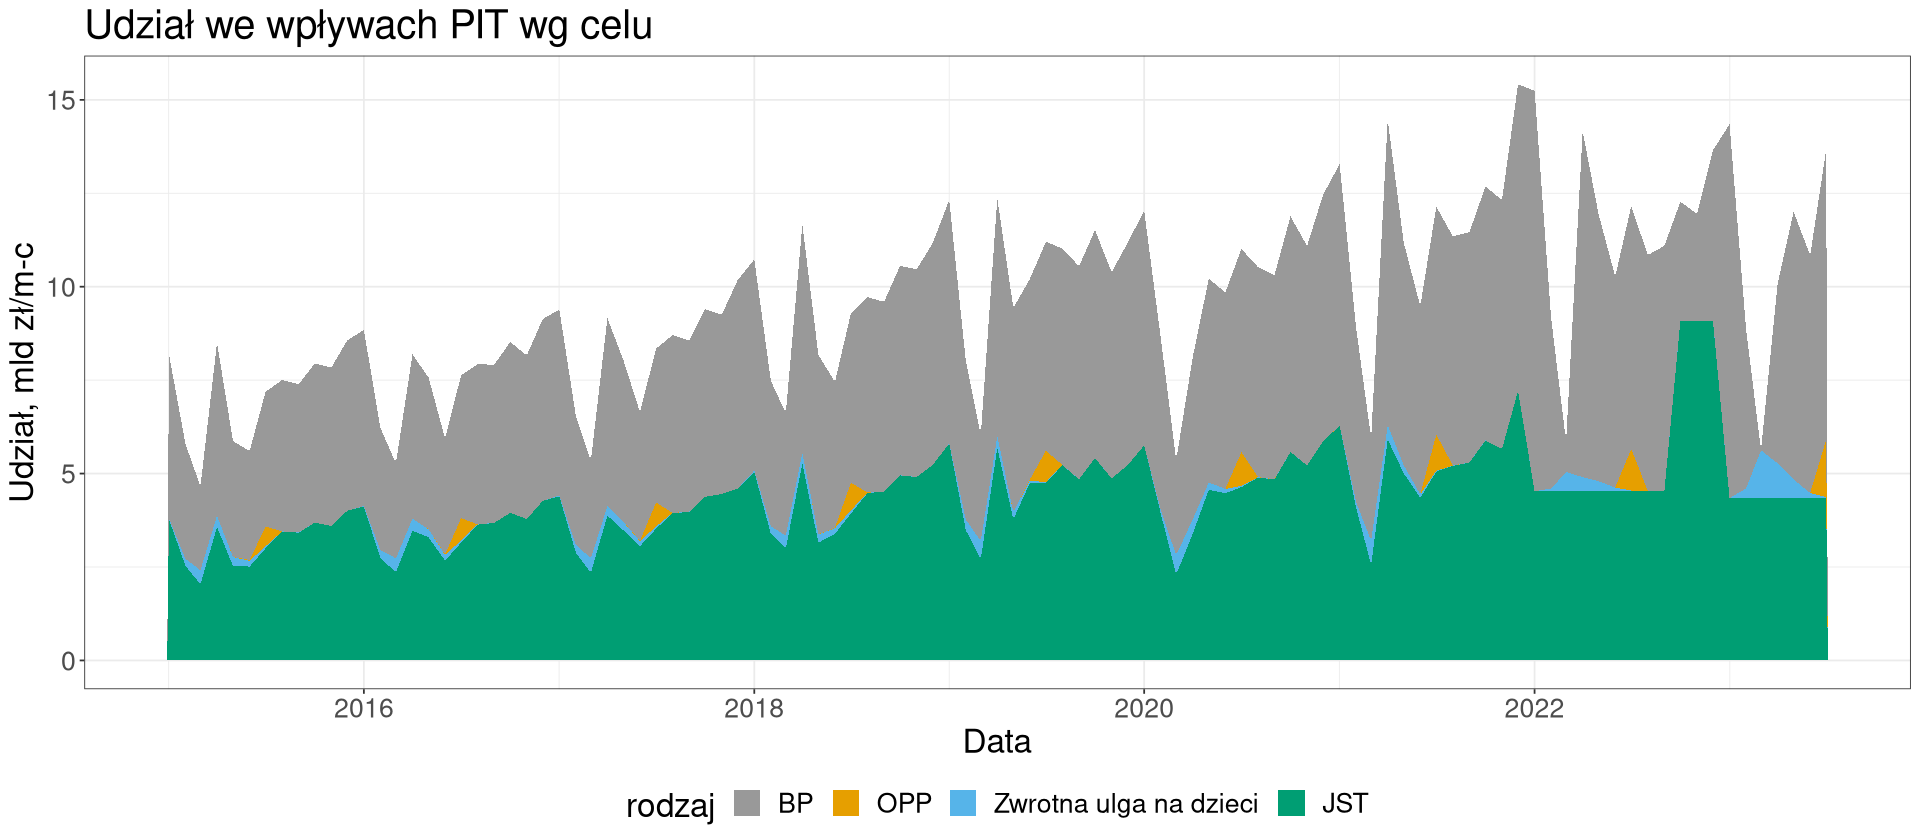

In [8]:
options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.scale = 1.5)

doch_pit[rodzaj != "Całkowite wpływy", .(data, rodzaj, suma_mld = fcase(rodzaj == "BP", pmax(suma_mld, 0), rodzaj != "BP", -suma_mld))] %>%
    ggplot(aes(x = data, y= suma_mld, fill = rodzaj)) + geom_area() + 
    labs(x="Data", y = "Udział, mld zł/m-c", title="Udział we wpływach PIT wg celu") +
    color_fill

Na wykresie może tego nie widać tak dobrze, ale w wyniku wysokich zwrotów na rozliczeniu rocznym miesięczne całkowite wpływy z PIT były na tyle niskie, że aby zapewnić zwroty ulgi na dzieci oraz stałe raty dla JST BP był w tym miesiącu na minusie.

Patrząc na poprzednie lata widać odpowiednio wysoki spadek w dochodach JST z PIT z tytułu rozliczenia rocznego właśnie w okolicach marca. Gdyby nie przejście na stałe raty dla JST, to w marcu 2022 r. JST by nie miały w ogóle dochodów z PIT.

In [9]:
doch_pit[rok == 2023] %>% 
    dcast(data~rodzaj, value.var = "suma_mld") %>%
    kable("html", caption = "Udział we wpływach PIT wg celu, miesięcznie dla 2023 r., mld zł") %>%
    as.character() %>%
    IRdisplay::display_html()

data,Całkowite wpływy,BP,OPP,Zwrotna ulga na dzieci,JST
2023-01-01,14.350,10.006,0.00,-0.001,-4.343
2023-02-01,8.862,4.261,0.00,-0.258,-4.343
2023-03-01,2.728,-2.895,0.00,-1.280,-4.343
2023-04-01,10.074,4.799,0.00,-0.932,-4.343
2023-05-01,12.008,7.168,0.00,-0.497,-4.343
2023-06-01,10.839,6.356,0.00,-0.140,-4.343
2023-07-01,13.666,7.765,-1.53,-0.028,-4.343


O ile same dochody JST się ustabilizowały w zakresie kwoty z PIT, to oznacza to z kolei, że ich udziały procentowe w całości wpływów w danym miesiącu są zmienne w czasie. Doskonale widać to na poniższych wykresach, gdzie po lewej mamy kwoty miesięczne, które się stabilizują od 2022 r., natomiast po prawej mamy udział w całości wpływów z PIT. Przed 2022 r. udział ten był w miarę stabilny i zmieniał się w miesiącach, gdzie było raz mniej, raz więcej wpływów z pozostałych rodzajów podatków, gdzie BP ma całkowity udział (ryczały, giełda, ryczałt od przychodów ewidencjonowanych). Natomiast po zamrożeniu kwoty, to udział ten szaleje i w III 2023 osiąga ponad 100% w wyniku wysokich zwrotów na rozliczeniu rocznym.

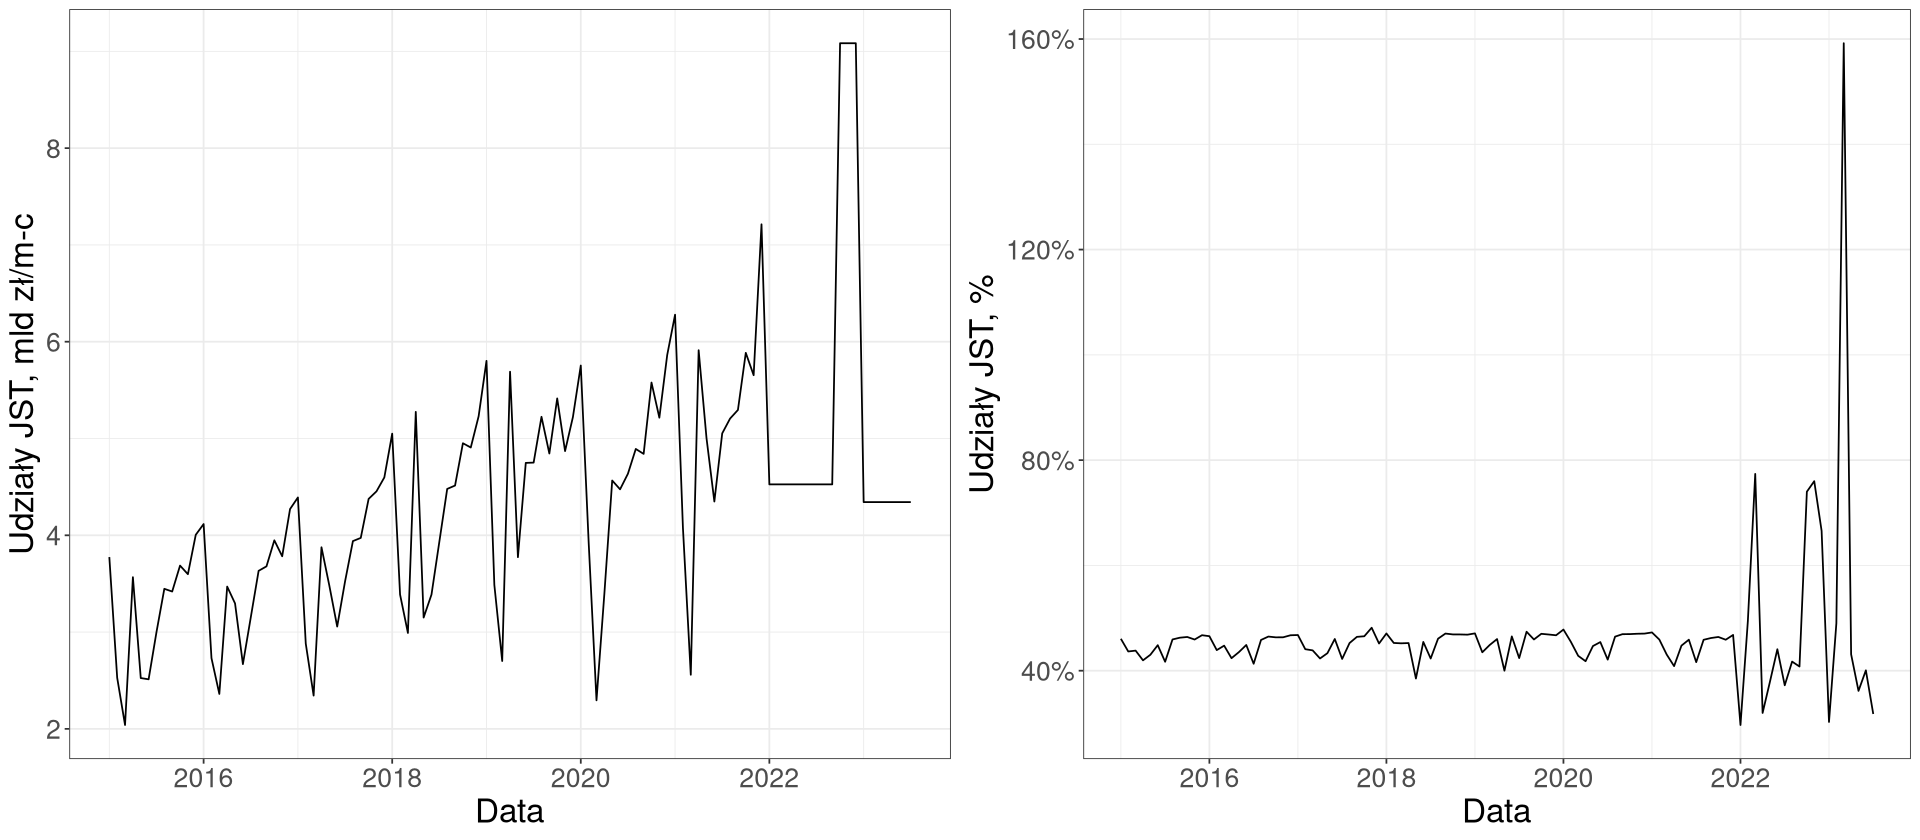

In [10]:
options(repr.plot.width = 16, repr.plot.height = 7, repr.plot.scale = 1.5)
jst_kwoty <- doch_pit %>% 
dcast(rok+miesiac~rodzaj, value.var = "suma_mld") %>%
    ggplot(aes(x = rok+(miesiac-1)/12, y= -JST )) + geom_line() +
    labs(x = "Data", y = "Udziały JST, mld zł/m-c")

jst_udzialy <- doch_pit %>% 
dcast(rok+miesiac~rodzaj, value.var = "suma_mld") %>%
    ggplot(aes(x = rok+(miesiac-1)/12, y= -JST / `Całkowite wpływy` )) + geom_line() +
    labs(x = "Data", y = "Udziały JST, %") + scale_y_continuous (labels = scales::percent)

grid.arrange(jst_kwoty, jst_udzialy, nrow=1, ncol=2)

## Udziały we wpływach PIT wg formy rozliczenia


Dodatkowo, dane w TREZOR-ze pozwalają na podział PIT względem formy rozliczenia. Ma to znaczenie o tyle, że nie we wszystkim samorządy mają swój udział. Jedynie w PIT na skali oraz linii. w CIT też, ale nie o CIT jest ten wpis.

Jeśli spojrzymy na udziały po rodzaju rozliczenia, to widać spadek znaczenia liniówki oraz wzrost ryczałtu w 2022 r.

In [11]:
# Udziały całkowitych wpływów wg źrógła

# Agregacja na główne składowe
doch_zrodlo <- doch[
    rozdzial %in% c("75601", "75604"), 
    .(suma_mld = round(sum(dochody_wykonane) / 1e9, 3)),
    by = .(
        rok, miesiac,
        rodzaj = fcase(
        paragraf == '0010' & rozdzial == '75604', 'linia',
        paragraf == '0010', 'skala',
        paragraf == '0030', 'ryczałt',
        paragraf == '0040', 'kapitałowe',
        default = 'pozostałe'
        ) %>% factor
    )
] 

# Zmień kolejność etykiet do wykresu
doch_zrodlo[, rodzaj := factor(rodzaj, levels = c("kapitałowe", "ryczałt", "linia", "skala", "pozostałe"))]
doch_wide <- doch_zrodlo[, .(suma_mld = round(sum(suma_mld), 3)), .(rok, rodzaj)] %>%
    dcast(rok~rodzaj, value.var = "suma_mld")
doch_wide[, .(rok, skala, linia, ryczałt, kapitałowe, pozostałe)] %>% 
    kable("html", caption = "Wpływy roczne PIT, wg formy rozliczenia, mld zł") %>%
    as.character() %>%
    IRdisplay::display_html()

rok,skala,linia,ryczałt,kapitałowe,pozostałe
2015,59.040,18.405,6.663,0.932,NA
2016,62.726,20.645,6.807,1.152,0.000
2017,67.894,22.942,7.543,1.156,0.002
2018,75.239,27.589,8.237,1.839,0.004
2019,80.934,32.332,9.326,1.614,0.013
2020,75.348,35.641,9.282,1.231,0.005
2021,85.887,38.999,10.942,2.757,0.009
2022,77.375,34.297,23.302,3.601,0.011
2023,31.193,18.765,19.717,2.851,0.000


W szczególności widać to na dynamikach rocznych, poniżej w %.

Na skali widać ujemną dynamikę całkowitych wpływów w 2020 r. oraz 2022 r. W pierwszym przypadku widoczne są efekty zmian wprowadzonych pod koniec 2019 r. czyli PIT-0 dla osó do 26 r.ż. (zwolnienie przychodu do ok. 85 tys. zł/rok z opodatkowania) oraz obniżenia stawki PIT z 18% do 17%. Zmiany te w pełni uwidoczniły się dopiero w 2020 r. Do tego doszła oczywiście pandemia w 2020 r.

Rok 2022 z kolei pokazuje efekty Niskich Podatków. Mamy spadek wpływów ze skali o ok. 10% przy wzroście przeciętnych wynagrodzeń o 12% [(Komunikaty GUS, przed rewizją)](https://stat.gov.pl/sygnalne/komunikaty-i-obwieszczenia/lista-komunikatow-i-obwieszczen/komunikat-w-sprawie-przecietnego-wynagrodzenia-w-gospodarce-narodowej-w-2022-roku,273,10.html) oraz waloryzacji rent i emerytur o 9% w marcu 2022 r. Do tego dochodzi zwolnienie 13. i 14. emerytury z PIT w 2022 r.

In [12]:
wybrane <- c("skala", "linia", "ryczałt", "kapitałowe")
doch_wide_dynamiki <- copy(doch_wide) 
doch_wide_dynamiki[
    rok < 2023, 
    (wybrane) := lapply(.SD, function(x){round(100 * (x/shift(x) - 1), 1) }), 
    .SDcols = wybrane
][
    rok < 2023, 
    .(rok, skala, linia, ryczałt, kapitałowe)
] %>% 
    kable("html", caption = "Wpływy roczne PIT, wg formy rozliczenia, dynamiki r/r, %") %>%
    as.character() %>%
    IRdisplay::display_html()


rok,skala,linia,ryczałt,kapitałowe
2015,NA,NA,NA,NA
2016,6.2,12.2,2.2,23.6
2017,8.2,11.1,10.8,0.3
2018,10.8,20.3,9.2,59.1
2019,7.6,17.2,13.2,-12.2
2020,-6.9,10.2,-0.5,-23.7
2021,14.0,9.4,17.9,124.0
2022,-9.9,-12.1,113.0,30.6


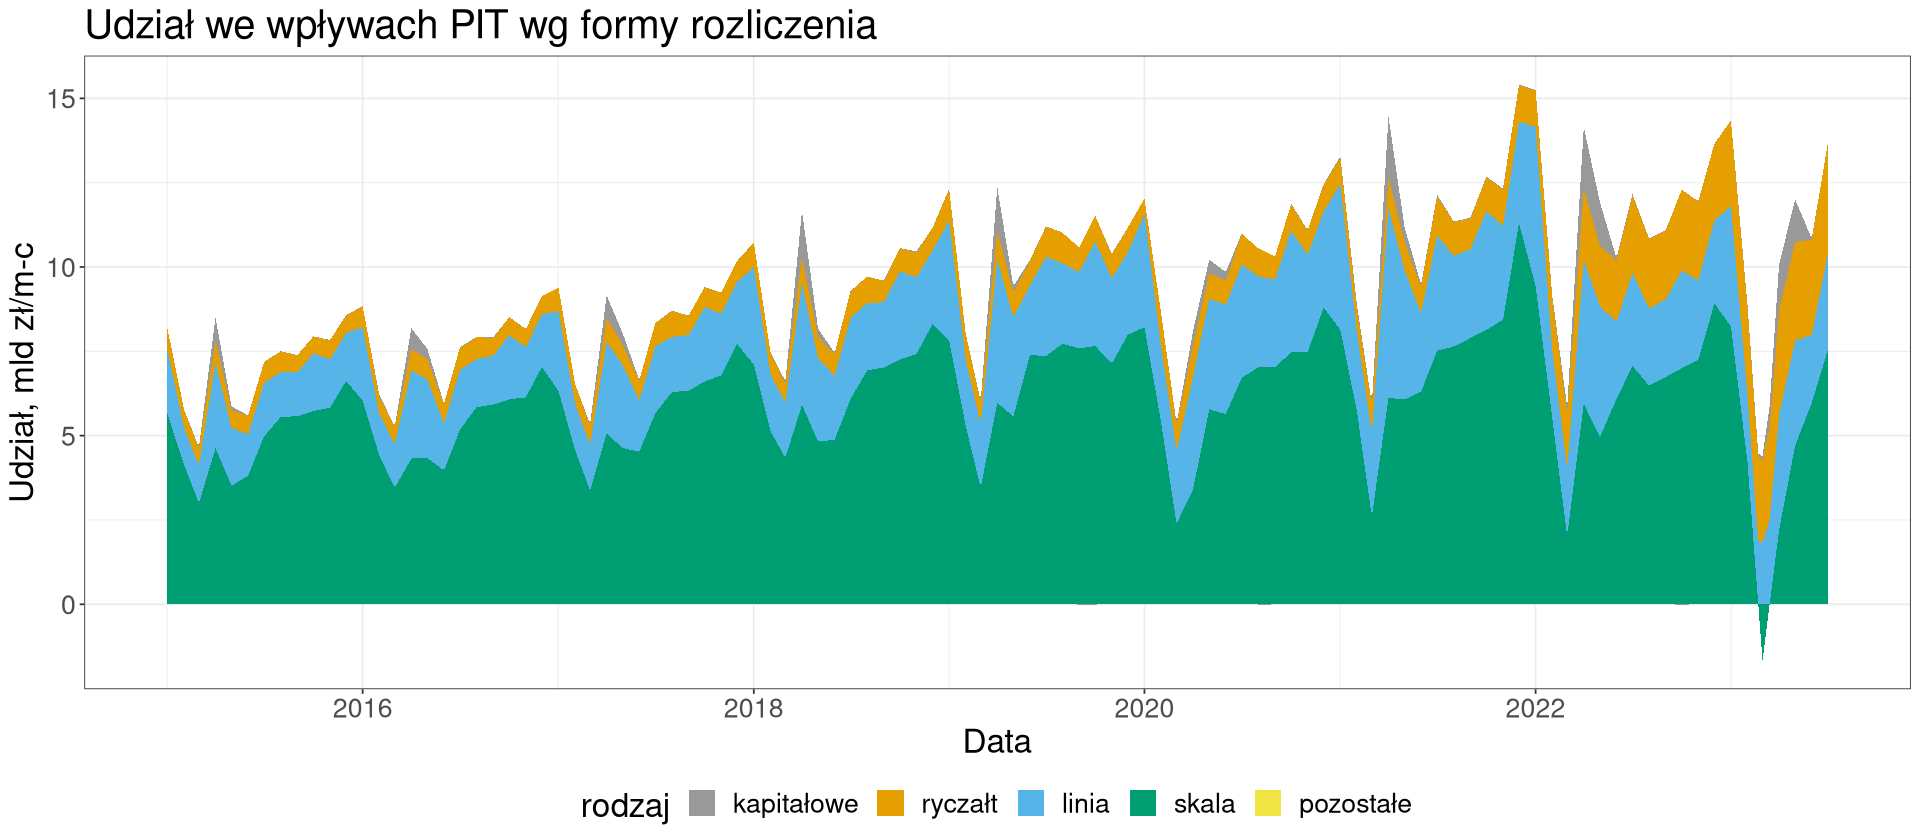

In [13]:
# Dodaj daty
doch_zrodlo[, data := as.Date(stringr::str_c(rok, "-", miesiac, "-01"))]
doch_zrodlo %>%
    ggplot(aes(x = data, y= suma_mld, fill = rodzaj)) + geom_area() + color_fill +
    labs(x="Data", y = "Udział, mld zł/m-c", title= "Udział we wpływach PIT wg formy rozliczenia")

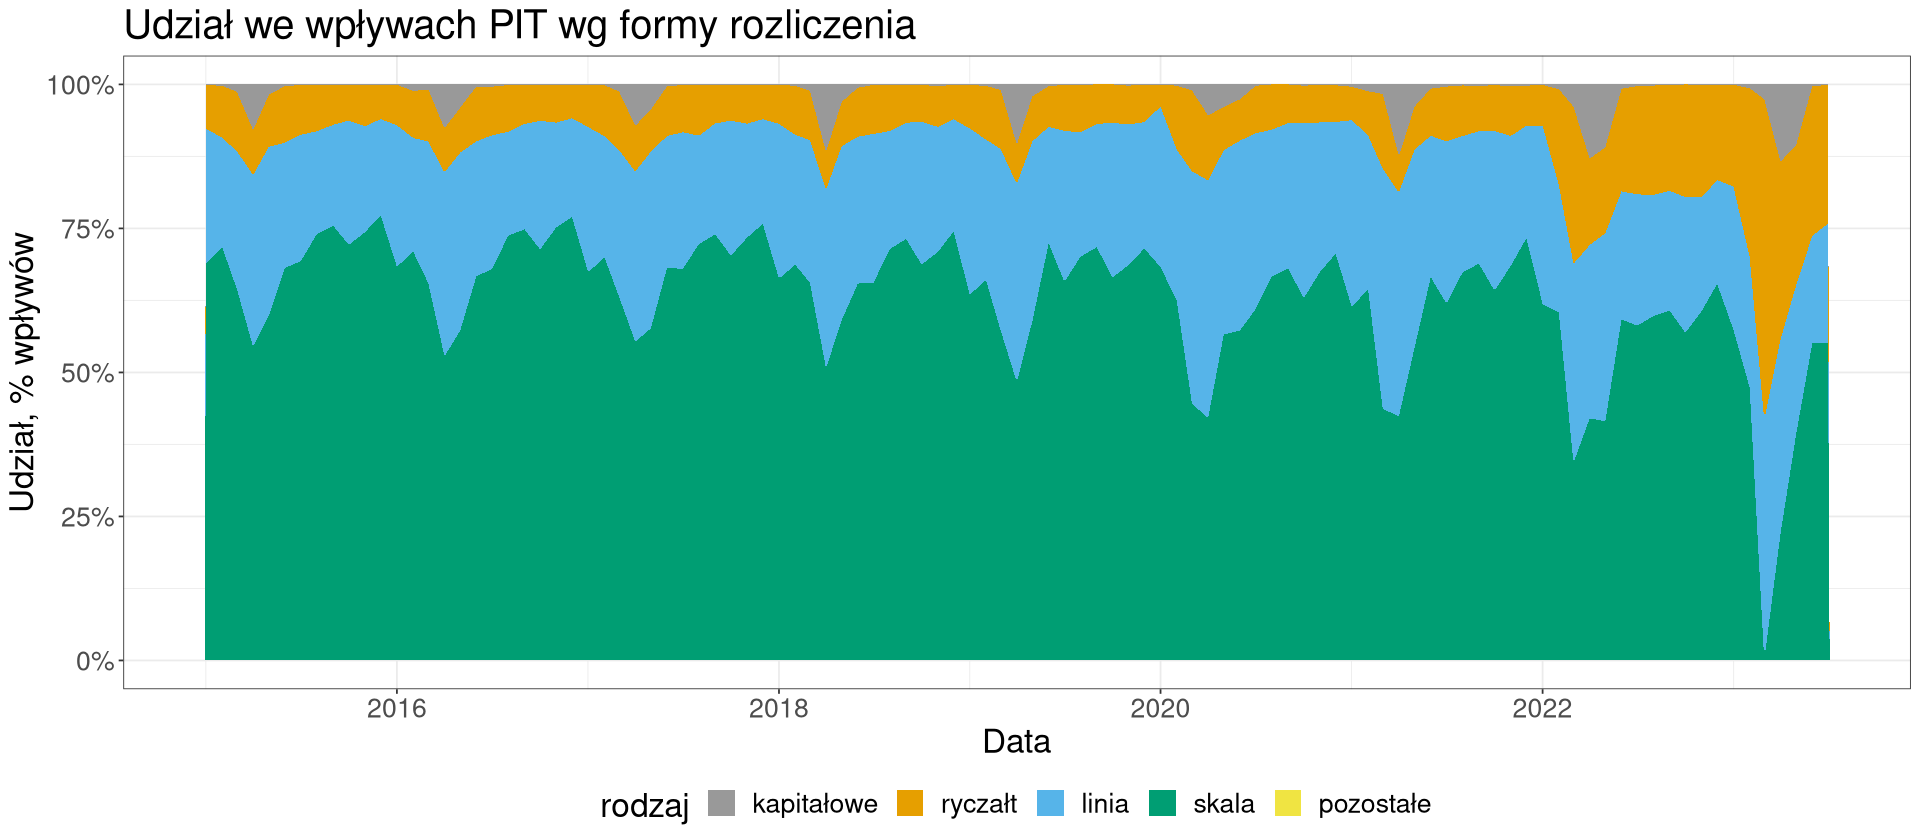

In [14]:
doch_zrodlo[, udzialy := pmax(suma_mld,0) / sum(pmax(suma_mld, 0)), .(data)]
doch_zrodlo %>%
    ggplot(aes(x = data, y= udzialy, fill = rodzaj)) + geom_area() + 
    scale_y_continuous (labels = scales::percent) + color_fill +
    labs(x="Data", y = "Udział, % wpływów", title= "Udział we wpływach PIT wg formy rozliczenia")

Warto też spojrzeć na zachowanie dochodów z PIT w ciągu roku w poszczególnych formach. 

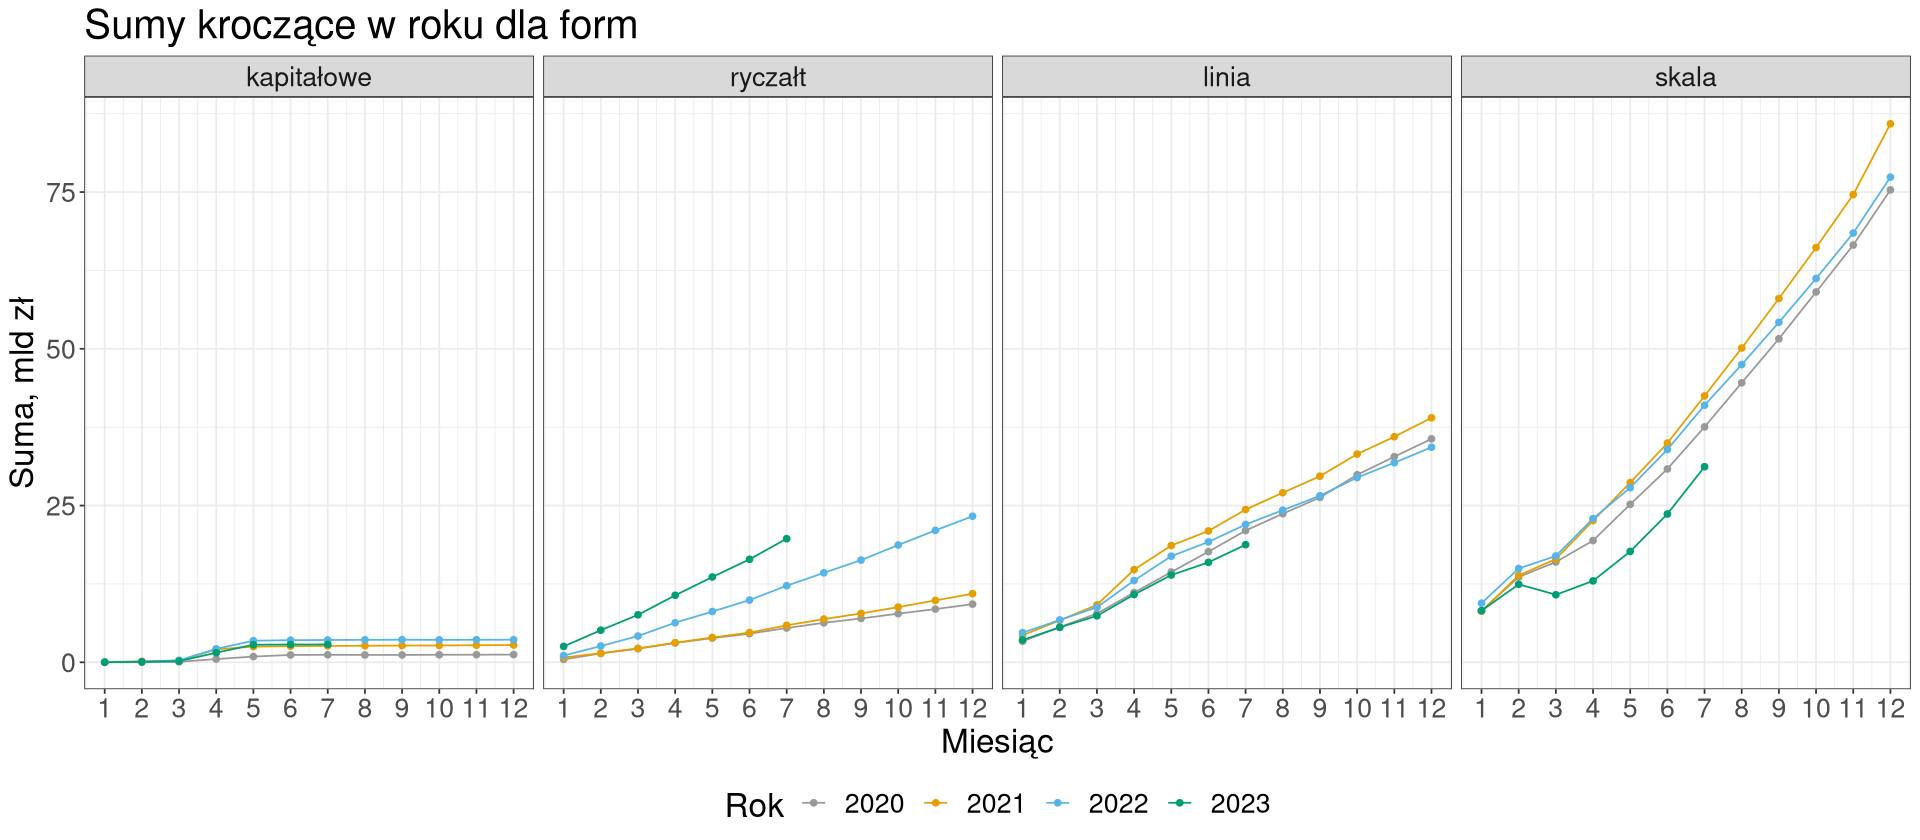

In [39]:
doch_zrodlo_cum <- doch_zrodlo[order(miesiac), .(miesiac, suma_cum = cumsum(suma_mld)), .(rok, rodzaj)]
doch_zrodlo_cum[rodzaj != "pozostałe" & rok >= 2020] %>%
    ggplot(aes(x = as.integer(miesiac), y = suma_cum, colour = factor(rok))) + geom_line() + geom_point()+
    facet_grid(~rodzaj) + color_color +
    scale_x_continuous(breaks=1:12) +
    labs(x = "Miesiąc", y = "Suma, mld zł", colour = "Rok", title= "Sumy kroczące w roku dla form")

In [55]:
skala_cum <- doch_zrodlo_cum[rodzaj == "skala" & rok >= 2021] %>%
    dcast(rodzaj + miesiac ~ rok, value.var = "suma_cum")

skala_cum[
    , 
    .(
        miesiac, 
        `2021`, prop_2021 = pperc(`2021` / max(`2021`)),
        `2022`, prop_2022 = pperc(`2022` / max(`2022`)),
        `2023`
    )
] %>% 
    kable("html", caption = "Wpływy roczne ze skali podatkowej, kumulatywnie w roku") %>%
    as.character() %>%
    IRdisplay::display_html()


miesiac,2021,prop_2021,2022,prop_2022,2023
1,8.143,9.5%,9.431,12.2%,8.239
2,13.871,16.2%,14.962,19.3%,12.439
3,16.468,19.2%,16.965,21.9%,10.775
4,22.594,26.3%,22.911,29.6%,12.980
5,28.661,33.4%,27.863,36.0%,17.687
6,34.965,40.7%,33.942,43.9%,23.655
7,42.484,49.5%,41.008,53.0%,31.193
8,50.130,58.4%,47.488,61.4%,NA
9,58.017,67.6%,54.224,70.1%,NA
10,66.153,77.0%,61.216,79.1%,NA


In [60]:
linia_cum <- doch_zrodlo_cum[rodzaj == "linia" & rok >= 2021] %>%
    dcast(rodzaj + miesiac ~ rok, value.var = "suma_cum")

linia_cum[
    , 
    .(
        miesiac, 
        `2021`, prop_2021 = pperc(`2021` / max(`2021`)),
        `2022`, prop_2022 = pperc(`2022` / max(`2022`)),
        `2023`
    )
] %>% 
    kable("html", caption = "Wpływy roczne z podatku liniowego, kumulatywnie w roku") %>%
    as.character() %>%
    IRdisplay::display_html()

miesiac,2021,prop_2021,2022,prop_2022,2023
1,4.313,11.1%,4.725,13.8%,3.563
2,6.682,17.1%,6.753,19.7%,5.576
3,9.158,23.5%,8.777,25.6%,7.408
4,14.781,37.9%,13.037,38.0%,10.808
5,18.625,47.8%,16.928,49.4%,13.918
6,20.951,53.7%,19.210,56.0%,15.941
7,24.368,62.5%,21.980,64.1%,18.765
8,27.053,69.4%,24.265,70.7%,NA
9,29.686,76.1%,26.573,77.5%,NA
10,33.205,85.1%,29.468,85.9%,NA


In [57]:
rycz_cum <- doch_zrodlo_cum[rodzaj == "ryczałt" & rok >= 2021] %>%
    dcast(rodzaj + miesiac ~ rok, value.var = "suma_cum")

rycz_cum[
    , 
    .(
        miesiac, 
        `2021`, prop_2021 = pperc(`2021` / max(`2021`)),
        `2022`, prop_2022 = pperc(`2022` / max(`2022`)),
        `2023`
    )
] %>% 
    kable("html", caption = "Wpływy roczne z ryczałtu od przychodów ewidencjonowanych, kumulatywnie w roku") %>%
    as.character() %>%
    IRdisplay::display_html()


miesiac,2021,prop_2021,2022,prop_2022,2023
1,0.772,7.1%,1.073,4.6%,2.536
2,1.450,13.3%,2.598,11.1%,5.126
3,2.222,20.3%,4.194,18.0%,7.572
4,3.129,28.6%,6.315,27.1%,10.688
5,3.965,36.2%,8.099,34.8%,13.609
6,4.741,43.3%,9.927,42.6%,16.427
7,5.897,53.9%,12.213,52.4%,19.717
8,6.894,63.0%,14.271,61.2%,NA
9,7.795,71.2%,16.302,70.0%,NA
10,8.805,80.5%,18.709,80.3%,NA


## Podsumowanie

Oczywiście jest to tylko drobny ułamek tego, co w tych danych siedzi. Jak będę miał trochę czasu to może spróbuję wrzucać dalsze wyniki eksploracji tego zbioru. Ciekawe tematy:

* Pozostałe dochody;
* Wydatki ogółem i po działach;
* Wydatki na wynagrodzenia;
* Funkcjonowanie jednostek podległych wojewodom;
* Rozszerzenie o pozostałe fundusze. 

Zaznaczam też, że wszystko co powyżej napisałem to efekt pracy w czasie wolnym, którego ostatnio u mnie jak na lekarstwo.